In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
# All things necessary to run the simulation
from hamopy import ham_library as ham
from hamopy.classes import Mesh, Boundary, Time
from hamopy.algorithm import calcul
from hamopy.postpro import evolution

In [3]:
# Choice of materials
from hamopy.materials.hamstad import BM4_load, BM4_finishing

In [4]:
# The liquid permeability of the load material is defined by a table as function of the suction pressure
k_file = 'BM4 Perm.txt'
dataK = pd.read_csv(k_file, delimiter='\t')
PC = -10**( np.array(dataK['log(Psuc)']) )
KL =  10**( np.array(dataK['log(K)']) )
# Setting the liquid permeability of BM4_load
BM4_load.set_perm_liquid('interp', **{"PC" : PC[::-1],
                                      "KL" : KL[::-1]})

In [5]:
# Geometry
mesh = Mesh(**{"materials"    : [BM4_load, BM4_load, BM4_load, BM4_finishing, BM4_finishing],
               "sizes"        : [0.01, 0.08, 0.01, 0.005, 0.015],
               "nbr_elements" : [100, 100, 100, 100, 100] })

In [40]:
# Boundary conditions
clim_file = 'BM4 Climate.txt'

clim1 = Boundary('Fourier',**{"file" : clim_file,
                              "time" : "time (s)",
                              "T"    : 293.15, #"Ta,e",
                              #"T_eq" : 293.15, #"Teq,e",
                              "HR"   : 0.6,
                              #"p_v"  : "pa,e",
                              #"g_l"  : 0, #"gl (kg/m2s)",
                              "h_t"  : 25,
                              "h_m"  : 2e-7 })

clim2 = Boundary('Fourier',**{"file" : clim_file,
                              "time" : "time (s)",
                              "T"    : 293.15, #"Teq,i",
                              "HR"   : 0.6,
                              #"p_v"  : "pa,i",
                              "h_t"  : 8,
                              "h_m"  : 3e-8 })

clim = [clim1, clim2]

In [41]:
# Initial conditions
init = {'T'  : 293.15,
        'PC' : -120738829}

# Time discretisation
time = Time('variable',**{"delta_t"  : 600,
                          "t_max"    : 432000,
                          "iter_max" : 12,
                          "delta_min": 1e-3,
                          "delta_max": 600 } )

# Saving the log somewhere
diary = 'log'


In [42]:
# Calculation
result = calcul(mesh, clim, init, time, logfile = diary)


In [43]:
# Postprocessing
data0 = pd.read_csv(clim_file, delimiter='\t')
t_plot = result['t']
x_plot = [0., 0.1, 0.12]
Temperature = np.column_stack([evolution(result, 'T', _, t_plot) for _ in x_plot]) - 273.15
Humidity    = np.column_stack([evolution(result, 'HR', _, t_plot) for _ in x_plot])
MoistureContent1 = BM4_load.w(ham.p_c(Humidity[:,0], Temperature[:,0]+273.15), Temperature[:,0]+273.15)
MoistureContent2 = BM4_load.w(ham.p_c(Humidity[:,1], Temperature[:,1]+273.15), Temperature[:,1]+273.15)
MoistureContent3 = BM4_finishing.w(ham.p_c(Humidity[:,1], Temperature[:,1]+273.15), Temperature[:,1]+273.15)
MoistureContent4 = BM4_finishing.w(ham.p_c(Humidity[:,2], Temperature[:,2]+273.15), Temperature[:,2]+273.15)

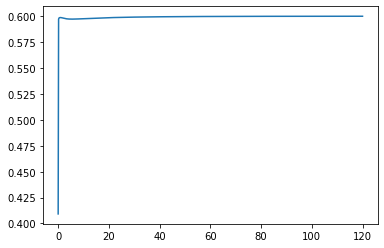

In [44]:
# Plotting the results
plt.figure()
plt.plot(t_plot/3600, Temperature[:,0])
plt.show()

plt.figure()
plt.plot(t_plot/3600, Humidity[:,0])
plt.show()

plt.figure()
plt.plot(t_plot/3600, MoistureContent1, '-r')
plt.plot(t_plot/3600, MoistureContent2, '--r')
plt.plot(t_plot/3600, MoistureContent3, '-b')
plt.plot(t_plot/3600, MoistureContent4, '--b')
plt.plot([24, 24], [0, 200], '--k')
plt.show()